# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from FOMCDataPrep import DataPrep

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

In [3]:
def prep_yields() -> pd.DataFrame: 

    df_yield = (DataPrep().get_tsy_yields().reset_index().rename(
        columns = {"DATE": "Date"}).
        assign(Date = lambda x: pd.to_datetime(x.Date).dt.date).
        melt(id_vars = "Date").
        dropna())
    
    return df_yield

df_yield = prep_yields()

Searching for data
Found Data


In [4]:
def get_yield_window(before = -3, after = 3) -> pd.DataFrame:
    
    df_dates = BBGCollect()._get_days_window(ticker = "FDTR", before = before, after = after)

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row
        df_tmp = df_yield.query("@start_date <= Date <= @end_date")
        df_combined = pd.concat([df_combined, df_tmp])
        
    return df_combined

df_yield_window = get_yield_window()

In [5]:
def get_window_yield(df_yield: pd.DataFrame, df_yield_window: pd.DataFrame) -> pd.DataFrame: 

    df_out = pd.DataFrame()
    tsys = df_yield_window.variable.drop_duplicates().to_list()

    for tsy in tsys:

        df_yield_tmp = df_yield.query("variable == @tsy")

        df_yield_window_tmp = (df_yield_window.query(
            "variable == @tsy").
            rename(columns = {"value": "window"}))

        start_date = df_yield_window_tmp.Date.min()
        start_yield = df_yield_tmp.query("Date == @start_date").value.iloc[0]

        df_tmp = (df_yield_tmp.query(
            "Date >= @start_date").
            merge(right = df_yield_window_tmp, how = "outer", on = ["Date", "variable"]).
            sort_values("Date").
            assign(
                yield_change = lambda x: x.value.diff(),
                window_change = lambda x: np.where(x.window == x.window, x.yield_change, 0),
                cum_window_change = lambda x: x.window_change.cumsum(),
                test = lambda x: start_yield + x.cum_window_change)
            [["Date", "variable", "test", "value"]])

        df_out = pd.concat([df_out, df_tmp])
        
    return df_out    
    
df_hypothetical_yield = get_window_yield(df_yield, df_yield_window)

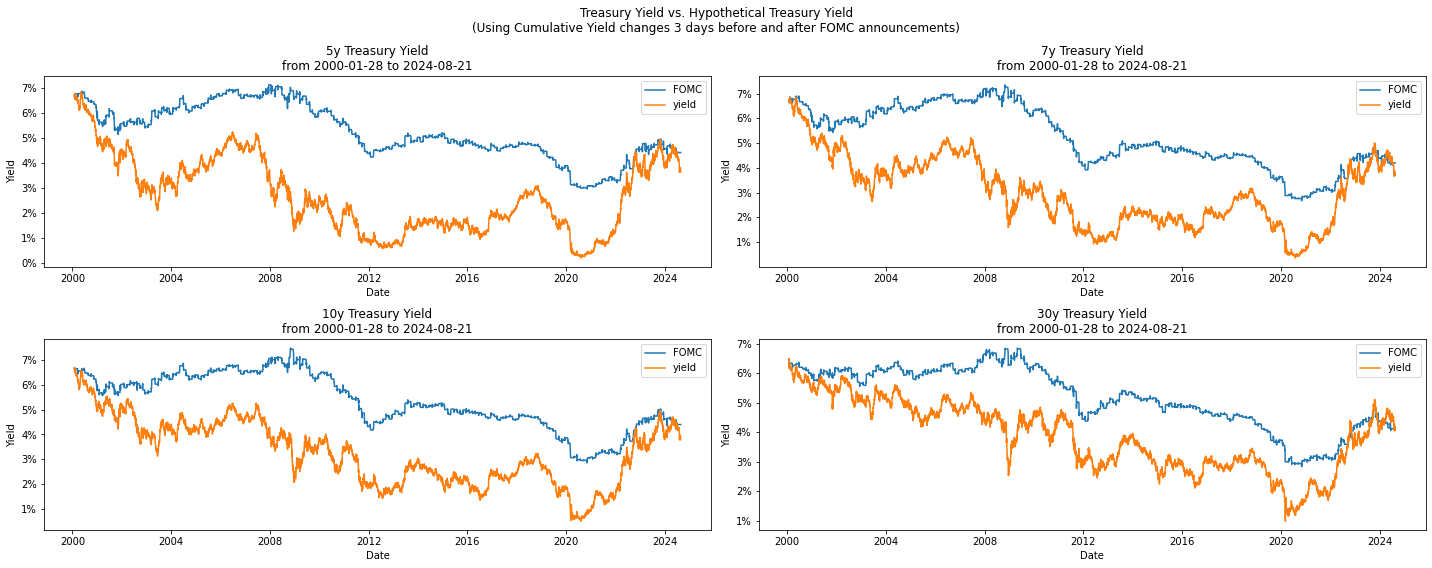

In [6]:
def plot_hypothetical_yield(df_hypothetical_yield: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y"}

    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20,8))

    for ticker, ax in zip(renamer.keys(), axes.flatten()):

        df_tmp = (df_hypothetical_yield.query(
            "variable == @ticker").
            rename(columns = {
                "test": "FOMC",
                "value": "yield"}).
            drop(columns = ["variable"]).
            set_index("Date"))

        (df_tmp.plot(
            ax = ax,
            ylabel = "Yield",
            title = renamer[ticker] + " Treasury Yield\nfrom {} to {}".format(
                df_tmp.index.min(),
                df_tmp.index.max())))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))


    fig.suptitle("Treasury Yield vs. Hypothetical Treasury Yield\n(Using Cumulative Yield changes 3 days before and after FOMC announcements)")
    plt.tight_layout()
    
plot_hypothetical_yield(df_hypothetical_yield)

In [19]:
def _get_regression(df: pd.DataFrame) -> pd.DataFrame: 
    
    regression = (sm.OLS(
        endog = df.test,
        exog = sm.add_constant(df.value)).
        fit())
    
    display(regression.fittedvalues)

(df_hypothetical_yield.query("variable == variable.min()").groupby(
    "variable").
    apply(_get_regression))

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6149   NaN
6150   NaN
6151   NaN
6152   NaN
6153   NaN
Length: 6154, dtype: float64

""
